In [ ]:
!pip install pyswarm


  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=caf9fc1eb6fc731b65256b68a6b8e840e8df81832c624777fb80b96b11e4469c
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from pyswarm import pso
import matplotlib.pyplot as plt


In [ ]:
## data preprocessing

train_path = '/content/drive/MyDrive/project file/archive (6)/Training'
test_path = '/content/drive/MyDrive/project file/archive (6)/Testing'

def load_data(data_path):
    data = []
    labels = []
    class_names = sorted(os.listdir(data_path))
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(data_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (64, 64))
            data.append(img)
            labels.append(class_index)
    return np.array(data), np.array(labels)

X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert labels to categorical
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


In [ ]:
def create_cnn_model(learning_rate, num_filters, dense_units, dropout_rate):
    model = Sequential()
    model.add(Conv2D(int(num_filters), (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(int(dense_units), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def evaluate_model(params):
    learning_rate, num_filters, dense_units, dropout_rate, batch_size = params
    model = create_cnn_model(learning_rate, num_filters, dense_units, dropout_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=10, batch_size=int(batch_size), validation_split=0.2, callbacks=[early_stopping], verbose=1)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    return -accuracy  # Return negative accuracy for minimization

# PSO bounds definition
bounds = [
    (1e-5, 1e-2),  # learning_rate
    (16, 64),      # num_filters
    (64, 256),     # dense_units
    (0.1, 0.5),    # dropout_rate
    (16, 64)       # batch_size
]

# Run PSO
best_params, best_score = pso(evaluate_model, [b[0] for b in bounds], [b[1] for b in bounds], swarmsize=10, maxiter=10)

# Extract and print best hyperparameters found by PSO
print('Best hyperparameters found by PSO:')
print('Learning Rate:', best_params[0])
print('Number of Filters:', best_params[1])
print('Dense Units:', best_params[2])
print('Dropout Rate:', best_params[3])
print('Batch Size:', best_params[4])


Epoch 1/10
116/116 [==============================] - 4s 14ms/step - loss: 1.2759 - accuracy: 0.6672 - val_loss: 1.7120 - val_accuracy: 0.2867
Epoch 2/10
116/116 [==============================] - 1s 8ms/step - loss: 0.4203 - accuracy: 0.8455 - val_loss: 1.9380 - val_accuracy: 0.4222
Epoch 3/10
116/116 [==============================] - 1s 7ms/step - loss: 0.2872 - accuracy: 0.8978 - val_loss: 2.4107 - val_accuracy: 0.3449
Epoch 4/10
41/41 [==============================] - 0s 2ms/step
Epoch 1/10
122/122 [==============================] - 3s 10ms/step - loss: 1.2838 - accuracy: 0.5516 - val_loss: 2.0282 - val_accuracy: 0.2320
Epoch 2/10
122/122 [==============================] - 1s 7ms/step - loss: 0.5884 - accuracy: 0.7611 - val_loss: 2.3817 - val_accuracy: 0.2537
Epoch 3/10
122/122 [==============================] - 1s 6ms/step - loss: 0.4787 - accuracy: 0.8083 - val_loss: 2.5052 - val_accuracy: 0.2963
Epoch 4/10
41/41 [==============================] - 0s 5ms/step
Epoch 1/10
210/210

In [ ]:
final_model = create_cnn_model(best_params[0], best_params[1], best_params[2], best_params[3])
final_model.fit(X_train, y_train, epochs=10, batch_size=int(best_params[4]), validation_split=0.2)
final_loss, final_accuracy = final_model.evaluate(X_test, y_test)
print('Final test accuracy:', final_accuracy)


Epoch 1/10
128/128 [==============================] - 4s 10ms/step - loss: 1.0170 - accuracy: 0.6596 - val_loss: 2.1304 - val_accuracy: 0.3553
Epoch 2/10
128/128 [==============================] - 1s 7ms/step - loss: 0.3872 - accuracy: 0.8453 - val_loss: 1.5089 - val_accuracy: 0.5404
Epoch 3/10
128/128 [==============================] - 1s 7ms/step - loss: 0.2441 - accuracy: 0.9094 - val_loss: 2.6667 - val_accuracy: 0.4500
Epoch 4/10
128/128 [==============================] - 1s 7ms/step - loss: 0.1614 - accuracy: 0.9424 - val_loss: 2.0733 - val_accuracy: 0.5517
Epoch 5/10
128/128 [==============================] - 1s 7ms/step - loss: 0.1095 - accuracy: 0.9620 - val_loss: 4.4600 - val_accuracy: 0.3510
Epoch 6/10
128/128 [==============================] - 1s 8ms/step - loss: 0.0742 - accuracy: 0.9744 - val_loss: 2.9963 - val_accuracy: 0.4848
Epoch 7/10
128/128 [==============================] - 1s 9ms/step - loss: 0.0652 - accuracy: 0.9770 - val_loss: 3.1986 - val_accuracy: 0.5308
Epoch

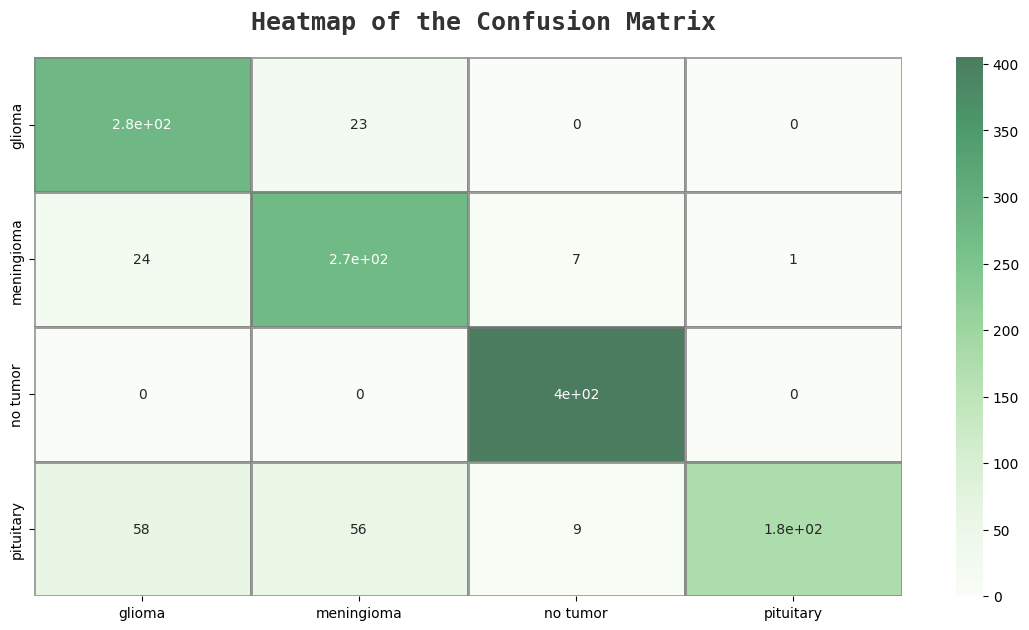

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # Add this line to import seaborn

# Assuming class_names is defined somewhere in your code
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes), ax=ax, xticklabels=class_names, yticklabels=class_names, annot=True,
            cmap='Greens', alpha=0.7, linewidths=2, linecolor='grey')
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color='black', y=0.92, x=0.28, alpha=0.8)
plt.show()


In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# Load your trained model


# Define class names according to your model's output
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']

def preprocess_image(image_path):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    # Resize the image to match the input size of your model
    img = cv2.resize(img, (64, 64))  # Adjust size according to your model's input shape
    # Preprocess the image: normalize pixel values
    img = img.astype('float32') / 255.0
    # Expand dimensions to match the batch size used by your model
    img = np.expand_dims(img, axis=0)
    return img

def predict_tumor_type(image_path):
    # Preprocess the image
    img = preprocess_image(image_path)
    # Predict tumor type using your model
    predictions = final_model.predict(img)
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    # Map the index to the class name
    predicted_class = class_names[predicted_class_index]
    return predicted_class

# Example usage:
image_path = '/content/drive/MyDrive/project file/archive (6)/Testing/glioma/Te-glTr_0000.jpg'  # Replace with the path to your image
predicted_tumor_type = predict_tumor_type(image_path)
print('Predicted tumor type:', predicted_tumor_type)


1/1 [==============================] - 0s 67ms/step
Predicted tumor type: glioma


In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# Load your trained model


# Define class names according to your model's output
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']

def preprocess_image(image_path):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    # Resize the image to match the input size of your model
    img = cv2.resize(img, (64, 64))  # Adjust size according to your model's input shape
    # Preprocess the image: normalize pixel values
    img = img.astype('float32') / 255.0
    # Expand dimensions to match the batch size used by your model
    img = np.expand_dims(img, axis=0)
    return img

def predict_tumor_type(image_path):
    # Preprocess the image
    img = preprocess_image(image_path)
    # Predict tumor type using your model
    predictions = final_model.predict(img)
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    # Map the index to the class name
    predicted_class = class_names[predicted_class_index]
    return predicted_class

# Example usage:
image_path = '/content/drive/MyDrive/project file/archive (6)/Testing/meningioma/Te-meTr_0004.jpg'  # Replace with the path to your image
predicted_tumor_type = predict_tumor_type(image_path)
print('Predicted tumor type:', predicted_tumor_type)


1/1 [==============================] - 0s 116ms/step
Predicted tumor type: meningioma


In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# Load your trained model


# Define class names according to your model's output
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']

def preprocess_image(image_path):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    # Resize the image to match the input size of your model
    img = cv2.resize(img, (64, 64))  # Adjust size according to your model's input shape
    # Preprocess the image: normalize pixel values
    img = img.astype('float32') / 255.0
    # Expand dimensions to match the batch size used by your model
    img = np.expand_dims(img, axis=0)
    return img

def predict_tumor_type(image_path):
    # Preprocess the image
    img = preprocess_image(image_path)
    # Predict tumor type using your model
    predictions = final_model.predict(img)
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    # Map the index to the class name
    predicted_class = class_names[predicted_class_index]
    return predicted_class


image_path = '/content/drive/MyDrive/project file/archive (6)/Testing/notumor/Te-no_0013.jpg'
predicted_tumor_type = predict_tumor_type(image_path)
print('Predicted tumor type:', predicted_tumor_type)


1/1 [==============================] - 0s 29ms/step
Predicted tumor type: no tumor
